In [301]:
import numpy as np
import pandas as pd
import os, sys
from datetime import datetime
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as smtsa
import matplotlib.pyplot as plt

% matplotlib inline

# Time Series Analysis: Diabetes

### Background
#### Diabetes Type 1 (Insulin-Dependent Diabetes Mellitus)
Patients with Type 1 Diabetes are insulin deficient due to either low or absent production of insukin by the pancreas' beta islet cells or insulin resistance. Insulin-deficiency may be prevalent despite normal readings of blood glucose levels. 

Treatment aims at maintaining normal blood glucose levels through routine monitoring, insulin therapy, and behavioral interventions (e.g. diet and exercise). Some insulin therapy involves the administration of exogenous insulin on a consistent basis. Essentially, the goal is to bring the average blood glucose level as close to the normal range as possible.

#### Blood Glucose Ranges
The concentration of blood glucose varys between individuals with normal pancreatic hormonal function. The range of normal *pre-meal* blood glucose readings is approximately: [80, 120] mg/dL.

##### Guidelines (Joslin Diabetes Center)
 | Blood Glucose (non-diabetics) | Blood Glucose (diabetics)
 :--|:--:|:--:
 Fasting (before breakfast) | 80-100 mg/dL | 70-130 mg/dL
 Before meal | 80-110 mg/dL | 70-130 mg/dL
 2 hours post-meal | 80-140 mg/dL | 80-180 mg/dL
 Bedtime | 80-120 mg/dL | 90-150 mg/dL


#### Dataset
The dataset collects blood glucose recordings of a patient on a daily basis during a specific interval.

Features:
  * **Date**
  * **Time**
  * **Code**: category identifier
  * **Value**: value associated with respective code type

The analysis will focus on pre-breakfast blood glucose measurement time series (code `58`).

### Purpose
Perform time series analysis of a patient's **pre-breakfast blood glucose measurements** taken prior to their meal.


### Research Questions
  1. Does the time series of pre-breakfast blood glucose measurement remain stationary (contant mean & variance) over time? In other words, does a trend exist?
  2. What is the seasonality (periodic behavior) of the time series?
    * Which interval has the strong serial correlation?
  
## Exploratory Analysis

In [264]:
# data path
cwd = os.getcwd()
db_path = os.path.join(cwd, 'data', 'Diabetes-Data', 'data-30')

cols = ['date','time', 'code', 'value']
dateparse = lambda dates: pd.datetime.strptime(dates, '%m-%d-%Y')
data = pd.read_csv(db_path, sep='\t', header = None, names=cols,
                   parse_dates = ['date'], date_parser = dateparse)
data['time'] = pd.to_datetime(data.time).dt.time
# data['time'] = pd.to_datetime(data.time).apply(lambda x: x.time())

print data.shape
data.head()

(1179, 4)


,date,time,code,value
0,1990-12-18,07:00:00,58,234
1,1990-12-18,07:00:00,33,6
2,1990-12-18,07:00:00,34,23
3,1990-12-18,11:30:00,60,212
4,1990-12-18,11:30:00,33,4


In [265]:
data_prebrkfst = data[data.code == 58] # filter for pre-breakfast glucose

# Group by Dates
dfts_prebrkfst = data_prebrkfst[['date', 'value']].groupby('date').agg(np.mean)
dfts_prebrkfst.index.name = None # remove index name
dfts_prebrkfst.head()

,value
1990-12-18,234
1990-12-19,212
1990-12-20,233
1990-12-21,261
1990-12-22,227


In [266]:
print "Average Pre-Breakfast Blood Glucose = %.2f mg/dL" % dfts_prebrkfst.mean()
print "Standard Deviation Pre-Breakfast Blood Glucose = %.2f mg/dL" % dfts_prebrkfst.std()

Average Pre-Breakfast Blood Glucose = 173.43 mg/dL
Standard Deviation Pre-Breakfast Blood Glucose = 59.48 mg/dL


In [267]:
monthly_means = dfts_prebrkfst.resample('M').mean().round(2)
monthly_std = dfts_prebrkfst.resample('M').std().round(2)
monthly_median = dfts_prebrkfst.resample('M').median().round(2)
monthly_max = dfts_prebrkfst.resample('M').max().round(2)
monthly_min = dfts_prebrkfst.resample('M').min().round(2)

monthly_concat = [monthly_means, monthly_std, monthly_median, 
                  monthly_max, monthly_min]
monthly_stats = pd.concat(monthly_concat, axis=1)
monthly_stats.columns = ['mean', 'std', 'median', 'max', 'min']
monthly_stats

,mean,std,median,max,min
1990-12-31,235.31,33.82,233.0,298,188
1991-01-31,165.58,73.99,141.0,319,59
1991-02-28,148.88,55.19,147.0,298,61
1991-03-31,167.47,44.14,160.5,268,80
1991-04-30,179.47,61.24,180.5,294,64
1991-05-31,177.61,42.55,179.5,252,72


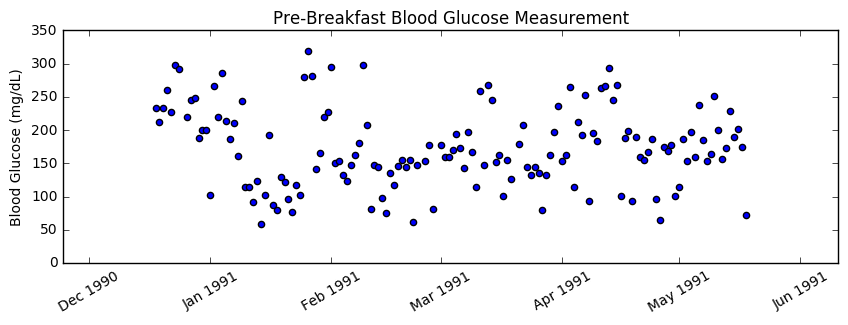

In [268]:
# Plot
plt.figure(figsize=(10,3))
plt.scatter(dfts_prebrkfst.index, dfts_prebrkfst.value)
plt.ylabel('Blood Glucose (mg/dL)')
plt.xticks(rotation=30)
plt.title('Pre-Breakfast Blood Glucose Measurement')
plt.show()

#### Conclusions
The pre-breakfast (fasting) blood glucose level of patient `30` appears to have an overall decreasing trend over time. More specifically, the mean blood glucose recordings decrease from December 1990 to February 1991, but the trend changes direction and begins to increase from March 1991 onwards. This could hint at the patient's change in other interventions such as lack of exercise or unhealthy diet, if the insulin therapy remains the same. Though, these inferences are difficult to conclude due to the data's volatility.

Additionally, preliminary conclusions include that the time series is not stationary as the mean and variance of the time series change over time is not constant.

## Evaluation of the Time Series' Stationarity (Trend Analysis)
A time series is believed to be stationary if no trend exists and if the following criteria are upheld:
  1. constance mean
  2. constance variance
  3. autocovariance independent of time

### Linear Regression
Fitting a regression model is one approach of extracting trends within a time series.

The explanatory variable (`x`) will be the number of days since the first measurement.

In [269]:
dfts_prebrkfst2 = dfts_prebrkfst.copy()

# Calculate days elapsed
dfts_prebrkfst2['date'] = dfts_prebrkfst2.index
start = dfts_prebrkfst2.date[0]
one_day = np.timedelta64(1, 'D')
dfts_prebrkfst2['days'] = (dfts_prebrkfst2.date - start) / one_day

dfts_prebrkfst2.head()

,value,date,days
1990-12-18,234,1990-12-18,0.0
1990-12-19,212,1990-12-19,1.0
1990-12-20,233,1990-12-20,2.0
1990-12-21,261,1990-12-21,3.0
1990-12-22,227,1990-12-22,4.0


In [270]:
model = smf.ols('value~days', data=dfts_prebrkfst2)
reg_results = model.fit()

print "Coefficients: "
print reg_results.params
print
print "p-value:"
print reg_results.pvalues['days']

Coefficients: 
Intercept    182.375826
days          -0.117791
dtype: float64

p-value:
0.289745501201


In [271]:
reg_results.rsquared

0.0076734620075716853

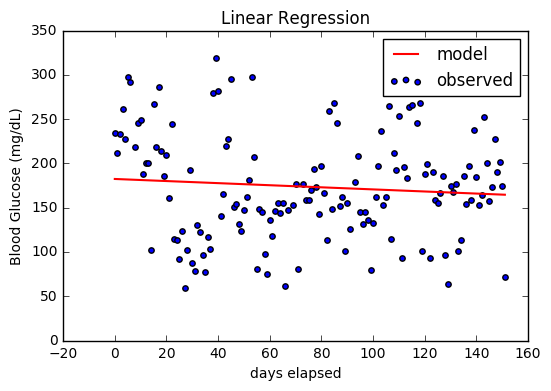

In [272]:
reg_xs = model.exog[:, 1] # explanatory var (days)
reg_ys = model.endog # blood glucose
plt.scatter(reg_xs, reg_ys, s=15, label='observed')
plt.plot(reg_xs, reg_results.fittedvalues, c='r', linewidth=1.5, 
         label='model')
plt.xlabel('days elapsed')
plt.ylabel('Blood Glucose (mg/dL)')
plt.title('Linear Regression')
plt.legend(loc='upper right')
plt.show()

#### Results
Model Coefficients:
  * β<sub>0</sub> (intercept) = 182.37 mg/dL
  * β<sub>1</sub> (slope) = -0.12

For every one unit increase in days, fasting blood glucose decreases by 0.12 units.

#### Conclusion
The linear regression model has a relatively high p-value (p-value > 0.05), providing poor evidence against the null hypothesis. Thus, H<sub>0</sub> is failed to be rejected.

In conclusion, there is no linear relationship between the days elapsed and pre-breakfast blood glucose. 

###  Moving Averages (Smoothing)
Moving averages are great approaches to extract underlying trends within a time series by computing averages for a series through overlapping windows.

Approaches:
  1. **Rolling Mean**
  2. **Exponentially-Weighted Moving Average (EWMA)**

##### Windows = 7 days
For our analysis, a window of `7 days` (weekly) will be used for weekly averages of pre-breakfast blood glucose measurements. 

### Missing Values
Missing (`NULL`) data must be dealt with before proceeding with further analyses. Previously, the missing data were simply dropped.

In [273]:
dates = pd.date_range(dfts_prebrkfst.index.min(), dfts_prebrkfst.index.max())
reindexed = dfts_prebrkfst.reindex(dates)
dates_nan = reindexed[reindexed.value.isnull()]
lst_dates_nan = dates_nan.index
dates_nan

,value
1990-12-25,NaN
1991-02-24,NaN
1991-02-28,NaN
1991-03-20,NaN


Pre-breakfast blood glucose was not recorded for patient `30` on 4 dates.

#### Rolling Mean
Rolling mean is a moving average based on the mean value in each window.

In [274]:
rolmean = pd.rolling_mean(reindexed, window=7) # roll weekly
rolstd = pd.rolling_std(reindexed, window=7)

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  if __name__ == '__main__':
/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).std()
  from ipykernel import kernelapp as app


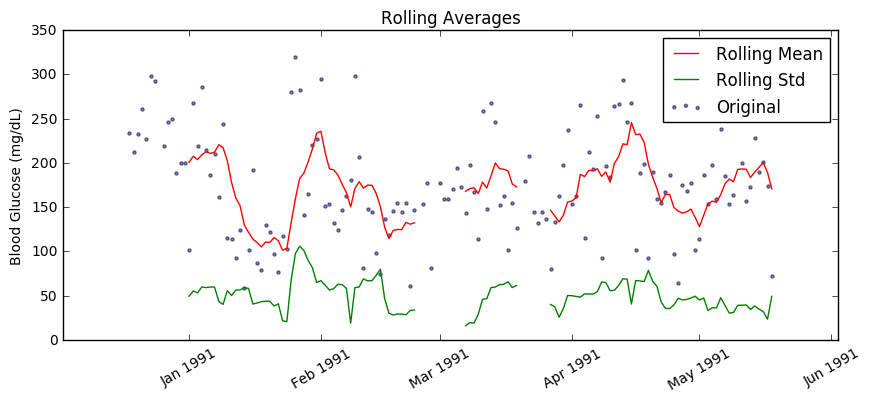

In [275]:
plt.figure(figsize=(10,4))
plt.scatter(reindexed.index, reindexed.value, c='blue', s=5, alpha=0.5, 
            label='Original')
plt.plot(rolmean.index, rolmean.value, c='red', label='Rolling Mean')
plt.plot(rolstd.index, rolstd.value, c='g', label='Rolling Std')
plt.ylabel('Blood Glucose (mg/dL)')
plt.xticks(rotation=30)
plt.title('Rolling Averages')
plt.legend(loc='best')
plt.show()

**Note**: `standard deviation` is plotted in place of `variance` for alignment of units.

There appears to be generally no trend with a relatively consistent mean and standard deviation.

#### Exponentially-Weighted Moving Average (EWMA)
EWMA is a moving average based on a *weighted* mean that gives the highest weight to the most recent values and exponentially decreases the weights of earlier values. In other words, weights are assigned to previous values with a decay factor.

**Note**: There are no missing values with EWMA as it handles `nan` values with its computation.

In [276]:
ewma = pd.ewma(reindexed.value, span=7) # roll weekly
ewma.head()

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=7,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


1990-12-18    234.000000
1990-12-19    221.428571
1990-12-20    226.432432
1990-12-21    239.074286
1990-12-22    235.116517
Freq: D, Name: value, dtype: float64

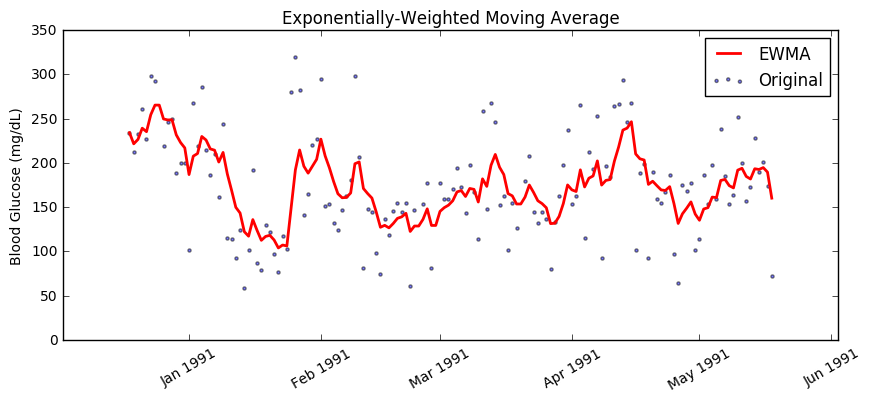

In [277]:
plt.figure(figsize=(10,4))
plt.scatter(reindexed.index, reindexed.value, c='blue', s=5, alpha=0.5, 
            label='Original')
plt.plot(ewma.index, ewma, c='red', linewidth=2.0, label='EWMA')
plt.ylabel('Blood Glucose (mg/dL)')
plt.xticks(rotation=30)
plt.title('Exponentially-Weighted Moving Average')
plt.legend(loc='best')
plt.show()

The EWMA plot appears to have a good amount of noise in the beginning (December 1990) due to fewer data points. Patient `30` began their glucose measurement in the middle of the month.

### Dickey-Fuller Test
#### Hypothesis
  * **H<sub>0</sub>**: The time series of pre-breakfast blood glucose measurements is non-stationary. It contains a trend.
  * **H<sub>A</sub>**: The time series of pre-breakfast blood glucose measurements is stationary. It contains no trend.

In [278]:
dft_results = adfuller(dfts_prebrkfst.value, autolag='AIC')
df_dft = pd.Series(dft_results[0:4], index = ['Test Statistic', 'p-value', 'n_lags', 'n_obs'])

for key, val in dft_results[4].items():
    df_dft['Critical Value (%s)' %key] = val

df_dft

Test Statistic         -7.844785e+00
p-value                 5.808164e-12
n_lags                  0.000000e+00
n_obs                   1.470000e+02
Critical Value (5%)    -2.881410e+00
Critical Value (1%)    -3.475637e+00
Critical Value (10%)   -2.577365e+00
dtype: float64

#### Conclusion
The null hypothesis is rejected in favor of the alternative as the p-value is small (`p-value < 0.05`) and provides substantial evidence against H<sub>0</sub>. Additionally, the test-statistic is not drastically larger than the critical values.

Thus, there appears to be trend and the time series is indeed stationary. There's a high probability that the series will follow the trend, or for better terms, lack of trend, in the future.

### Trend Analysis Conclusion
All approaches (linear regression, moving averages (smoothing), and the Dickey-Fuller) indicate that there is no trend within the time series and that it is stationary.

## Supplementary Analysis: Predict Missing Values
After characterizing the trend of the time series, missing data could be filled in by using **moving averages**. Resampling is used to generate the missing values with the right amount of noise, which is determined by EWMA for those specific days. Greater weight is given to recent dates close to the missing time series point, whereas further dates have decaying weight.

`reindexed` is the DataFrame with *all* dates, including those time points with missing values.

In [281]:
reindexed[reindexed.index.isin(lst_dates_nan)]

,value
1990-12-25,NaN
1991-02-24,NaN
1991-02-28,NaN
1991-03-20,NaN


In [282]:
reindexed_filled = reindexed.copy()
reindexed_filled.value.fillna(ewma, inplace=True)
reindexed_filled[reindexed_filled.index.isin(lst_dates_nan)]

,value
1990-12-25,265.135029
1991-02-24,128.619559
1991-02-28,129.284648
1991-03-20,153.505167


**Note**: A drawback of this approach is that the noise in the time series is understated.

A solution is to add *resampled residuals* of EWMA. The values will differ each time as the resampled residuals are random.

In [289]:
resid = (reindexed.value - ewma).dropna() # calculate EWMA residuals
resample = np.random.choice(resid, len(reindexed), replace=True) # resample
fake_data = ewma + resample

reindexed_filled2 = reindexed.copy()
reindexed_filled2.value.fillna(fake_data, inplace=True)
reindexed_filled2[reindexed_filled2.index.isin(lst_dates_nan)]

,value
1990-12-25,180.420747
1991-02-24,176.737602
1991-02-28,120.722624
1991-03-20,166.357480


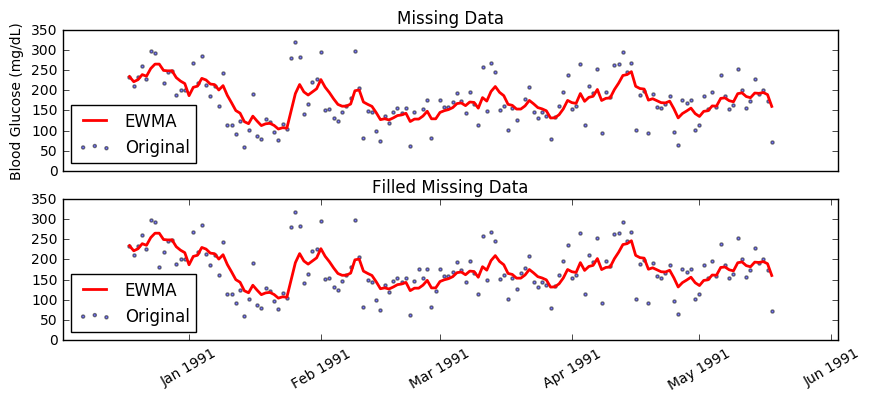

In [295]:
plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.scatter(reindexed.index, reindexed.value, c='blue', s=5, alpha=0.5, 
            label='Original')
plt.plot(ewma.index, ewma, c='red', linewidth=2.0, label='EWMA')
plt.ylabel('Blood Glucose (mg/dL)')
plt.xticks([])
plt.title('Missing Data')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.scatter(reindexed_filled2.index, reindexed_filled2.value, c='blue', s=5, alpha=0.5, 
            label='Original')
plt.plot(ewma.index, ewma, c='red', linewidth=2.0, label='EWMA')
# plt.ylabel('Blood Glucose (mg/dL)')
plt.xticks(rotation=30)
plt.title('Filled Missing Data')
plt.legend(loc='best')
plt.show()

The difference is not apparent to the naked eye due to the small number of missing values (4).

## Seasonality
Now that the trend, or lack of it has been determined, the next step is to investigate seasonality. Seasonality is periodic behavior, which may exhibit cycles on an periodic basis.

**Note**: The analysis will be conducted with the filled (EWMA-residual resampling) DataFrame. Thus, there are no missing values.

### Serial Correlation
Serial correlation is the correlation between a time series and a shifted/lagged version of itself. It determines a pattern where each value is correlate with the next one in the series.

In [300]:
for lag in [1, 7, 30, 365]: # daily, weekly, monthly, yearly lags
    scorr = reindexed_filled2['value'].autocorr(lag=lag)
    print 'lag = %d: \t %.3f' % (lag, scorr)

lag = 1: 	 0.394
lag = 7: 	 0.147
lag = 30: 	 0.151
lag = 365: 	 nan


#### Conclusion
Overall, the serial correlations for each periodic windows (*daily, weekly, and monthly*) are small. This indicates that there is little or no one-day, one-week, or one-month serial correlations in the series. In other words, the correlation between consecutive days, weeks, and months are relatively week.

A lag of 1 day has the highest serial correlation (`0.394`), suggesting that the strongest serial correlation is between *consecutive days*. Thus, the strongest correlation is a daily cycle, which may be due to volatility of blood glucose. The human physiology may fluctuate on a more granular time scale (days as opposed to weeks) due to the body's response to events such as diet and exercise.

Also to be noted, a lag of 365 (*yearly*) is `null` due to short window of the patient's glucose recording for the study. Patient 30's data is only available from the dates December 1990 - June 1991.

### Autocorrelation
Autocorrelation is a more general form of serial correlation, but for any amount of lag. It tests whether serial correlations are statistically significant, mapping each lag to its respctive serial correlation.

In [303]:
acf = smtsa.acf(reindexed_filled2['value'], nlags=30, unbiased=True)

for lag in [1, 7, 30]: # daily, weekly, monthly, yearly lags
    print 'lag = %d: \t %.3f' % (lag, acf[lag])

lag = 1: 	 0.391
lag = 7: 	 0.144
lag = 30: 	 0.147


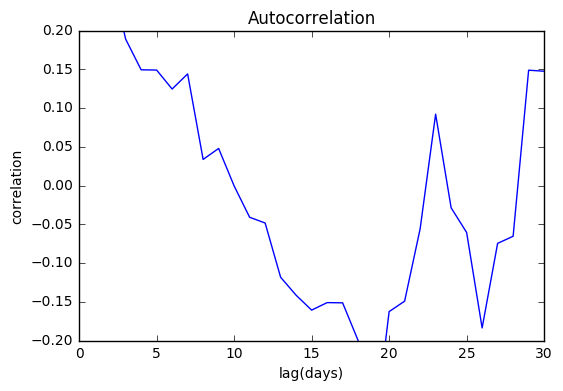

In [310]:
fig = plt.figure()
plt.plot(range(31)[1:], acf[1:])
plt.xlabel('lag(days)')
plt.ylabel('correlation')
plt.ylim([-0.20,0.20])
plt.title('Autocorrelation')
plt.legend(loc='lower right')

#### Conclusion
The autocorrelation method yielded similar results to the serial correlation as expected. It is essentially a more sophisticated/generalized version of serial correlation.

#### Plot
Per the plot, only lag of approximately days [7, 11], [22], [27,28] are within the region of normal variability (`-0.05 < y <0.05`), given no actual autocorrelation. Those values outside of this range are determined to be statistically significant with a p-value < 0.05.

### Conclusion
The time series of pre-breakfast blood glucose appears to have no trend (*stationary*) and its strongest serial correlation is on a weekly basis (*7 day lag*).

The fact that the series has no trend, a forecasting model to predict future values may be difficult. This is supported by the poor R<sup>2</sup> score of the linear regression model, demonstrating its poor predictive power.